#Importing the necessary libraries

In [83]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import cv2
import pandas as pd
from tensorflow import keras
from google.colab import drive
import os
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [79]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense, Convolution2D,\
                                    MaxPooling2D, LeakyReLU, MaxPool2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint 
from math import sin, cos, pi
import cv2
from tqdm.notebook import tqdm

Setting DataAugmentation Flags

In [4]:
TAKE_ONLY_CLEAN_DATA = True
HORIZONTAL_FLIP = True
ROTATE_IMAGES = True
ADD_NOISE_To_IMAGES = True
MODIFY_IMAGE_INTENSITY = True

In [5]:
print("TensorFlow Version : ", tf.__version__)
print("Keras Version : ", keras.__version__)
print("Open CV Python Version :", cv2.__version__)

TensorFlow Version :  2.3.0
Keras Version :  2.4.0
Open CV Python Version : 4.1.2


In [6]:

%cd gdrive/My\ Drive/

/content/gdrive/My Drive


In [7]:
dataFrameTrain = pd.read_csv('training.csv')

In [8]:
dataFrameTrain

left_eye_center_x  ...                                              Image
0             66.033564  ...  238 236 237 238 240 240 239 241 241 243 240 23...
1             64.332936  ...  219 215 204 196 204 211 212 200 180 168 178 19...
2             65.057053  ...  144 142 159 180 188 188 184 180 167 132 84 59 ...
3             65.225739  ...  193 192 193 194 194 194 193 192 168 111 50 12 ...
4             66.725301  ...  147 148 160 196 215 214 216 217 219 220 206 18...
...                 ...  ...                                                ...
7044          67.402546  ...  71 74 85 105 116 128 139 150 170 187 201 209 2...
7045          66.134400  ...  60 60 62 57 55 51 49 48 50 53 56 56 106 89 77 ...
7046          66.690732  ...  74 74 74 78 79 79 79 81 77 78 80 73 72 81 77 1...
7047          70.965082  ...  254 254 254 254 254 238 193 145 121 118 119 10...
7048          66.938311  ...  53 62 67 76 86 91 97 105 105 106 107 108 112 1...

[7049 rows x 31 columns]

In [9]:
dataFrameTrain.info(verbose=True) #gives the information of all columns in the data Frame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [10]:
def plot_datasets_using_images_and_keypoints(images, keypoints, n_rows=10, n_cols=10, fig_size=(20,20)):
  
  fig, axes = plt.subplots(n_rows, n_cols, figsize = fig_size)
  axes = axes.ravel()

  data_len = len(images)

  for i in range(0, n_rows*n_cols):
    index = np.random.randint(0, data_len)
    axes[i].imshow(images[index][:,:,0], cmap='gray')
    keypoints_data = keypoints[index]

    for j in range(1,len(keypoints_data)+1,2):
      axes[i].plot(keypoints_data[j-1],keypoints_data[j], 'bx')

    axes[i].axis('off')

In [11]:
def plot_datasets_using_dataFrame(data, n_rows=10, n_cols=10, fig_size=(20,20)):
    fig, axes = plt.subplots(n_rows,n_cols,figsize = fig_size)
    axes = axes.ravel()

    data_len = len(data)

    for i in range(0,n_rows*n_cols):
        index = np.random.randint(0,data_len)
        axes[i].imshow(data['Image'][index], cmap='gray')
        for j in range(1,31,2):
            axes[i].plot(data.loc[index][j-1], data.loc[index][j], 'rx')
        #axes[i].set_title(y_train[i], fontsize = 8)
        axes[i].axis('off')

In [12]:
cleanedDataFile = 'cleanedDataFile.csv'

In [13]:
dataFrameTrain.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [14]:
dataFrameTrain.isnull()

left_eye_center_x  left_eye_center_y  ...  mouth_center_bottom_lip_y  Image
0                 False              False  ...                      False  False
1                 False              False  ...                      False  False
2                 False              False  ...                      False  False
3                 False              False  ...                      False  False
4                 False              False  ...                      False  False
...                 ...                ...  ...                        ...    ...
7044              False              False  ...                      False  False
7045              False              False  ...                      False  False
7046              False              False  ...                      False  False
7047              False              False  ...                      False  False
7048              False              False  ...                      False  False

[7049 rows x 31 columns]

In [15]:
dataFrameTrainCopy = dataFrameTrain.copy()

In [16]:
dataFrameTrainCopy = dataFrameTrainCopy.dropna()
dataFrameTrainCopy.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [17]:
dataFrameTrainCopy.to_csv(cleanedDataFile, encoding='utf-8', index=False)


In [18]:
cleanedDataFrame = pd.read_csv(cleanedDataFile)

In [19]:
cleanedDataFrame

left_eye_center_x  ...                                              Image
0             66.033564  ...  238 236 237 238 240 240 239 241 241 243 240 23...
1             64.332936  ...  219 215 204 196 204 211 212 200 180 168 178 19...
2             65.057053  ...  144 142 159 180 188 188 184 180 167 132 84 59 ...
3             65.225739  ...  193 192 193 194 194 194 193 192 168 111 50 12 ...
4             66.725301  ...  147 148 160 196 215 214 216 217 219 220 206 18...
...                 ...  ...                                                ...
2135          67.180378  ...  191 191 191 190 189 185 184 120 54 34 19 24 31...
2136          65.724490  ...  19 19 19 18 13 7 3 4 3 1 3 9 11 12 12 13 10 9 ...
2137          68.430866  ...  31 40 47 31 54 58 63 100 86 80 82 75 79 86 90 ...
2138          64.152180  ...  7 1 5 1 3 20 12 0 5 8 6 18 13 9 8 12 12 11 4 8...
2139          66.683755  ...  68 19 19 23 19 26 23 16 8 15 9 9 17 16 15 27 2...

[2140 rows x 31 columns]

In [20]:
def get_images(dataFrame):

  dataFrame['Image'] = dataFrame['Image'].apply(lambda x: np.fromstring(x, dtype=int, sep=' '))
  dataFrame['Image'] = dataFrame['Image'].apply(lambda x: x.reshape(96,96))
  
  return dataFrame


In [21]:
if TAKE_ONLY_CLEAN_DATA:
  DataFrame_withImages = get_images(cleanedDataFrame) 
else:
  DataFrame_withImages = get_images(dataFrameTrain)

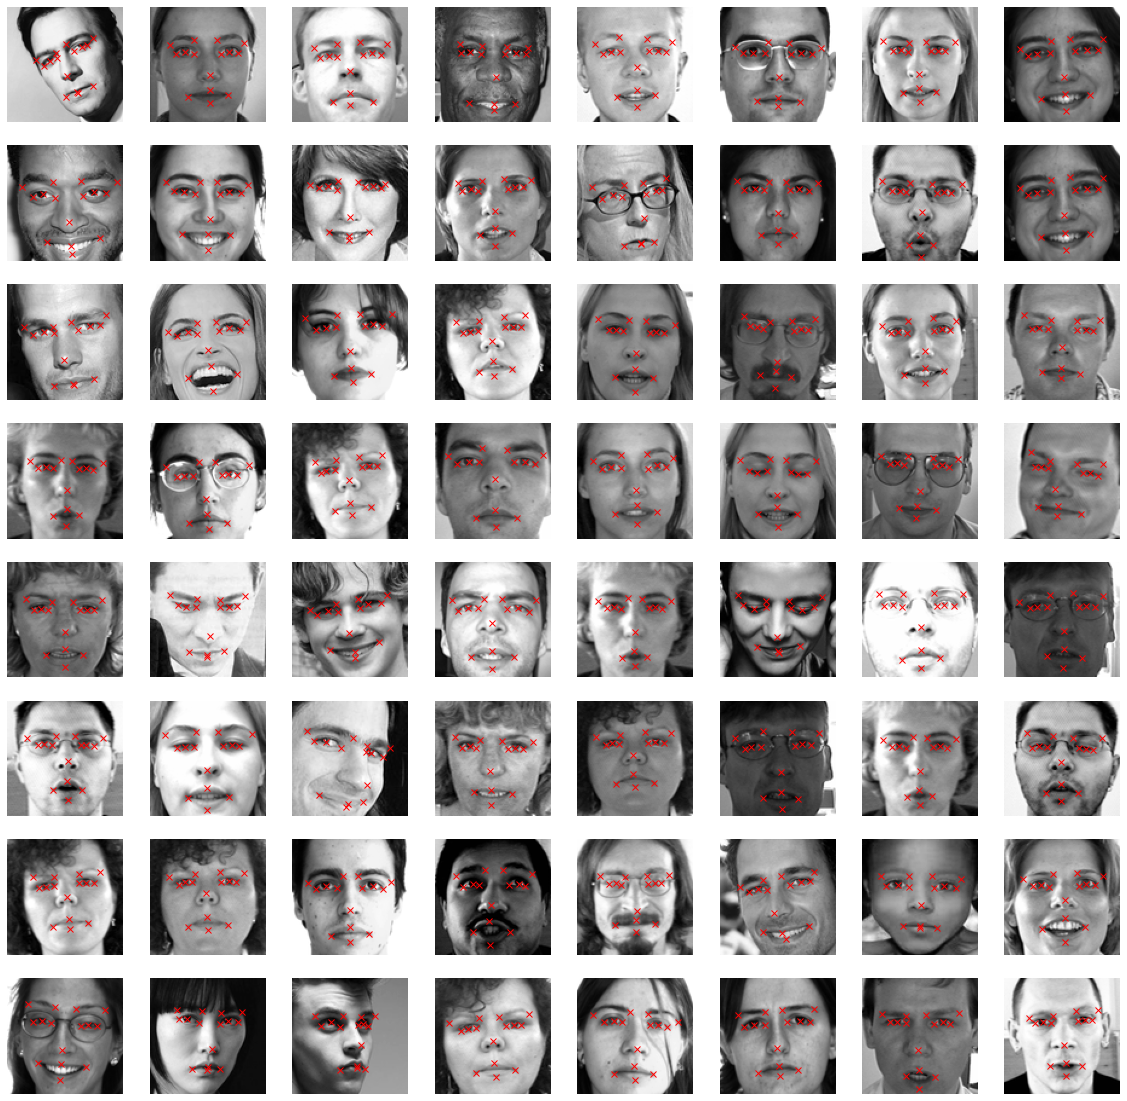

In [22]:
plot_datasets_using_dataFrame(DataFrame_withImages,8,8)

In [23]:
del dataFrameTrainCopy

In [24]:
labels = []
for i in range(len(DataFrame_withImages)):
    labels_temp = []
    for j in range(len(DataFrame_withImages.loc[0])-1):
        labels_temp.append(DataFrame_withImages.loc[i][j])
    labels.append(labels_temp)
    


In [25]:
images = DataFrame_withImages['Image']
images = images/255.0
X = np.empty((len(images), 96, 96, 1))
for i in range(len(images)):
    X[i,:] = np.expand_dims(images[i], axis=2)

X = np.asarray(X).astype(np.float32)

print(X.shape)
print(np.array(labels).shape)

(2140, 96, 96, 1)
(2140, 30)


In [26]:
def horizontal_flip(images, facial_keypoints):
    
    flipped_keypoints = []
    flipped_images = np.flip(images, axis=2)
    
    for idx, sample_keypoints in enumerate(facial_keypoints):
        flipped_keypoints.append([96.-point if idx%2==0 else point for idx,point in enumerate(sample_keypoints)])    # horizontal flipping involves only subratction of pixel from 96 in X direction 
    return flipped_images, flipped_keypoints

if HORIZONTAL_FLIP:
  flipped_train_images, flipped_train_keypoints = horizontal_flip(X, labels)
else:
  flipped_train_images, flipped_train_keypoints = [], []

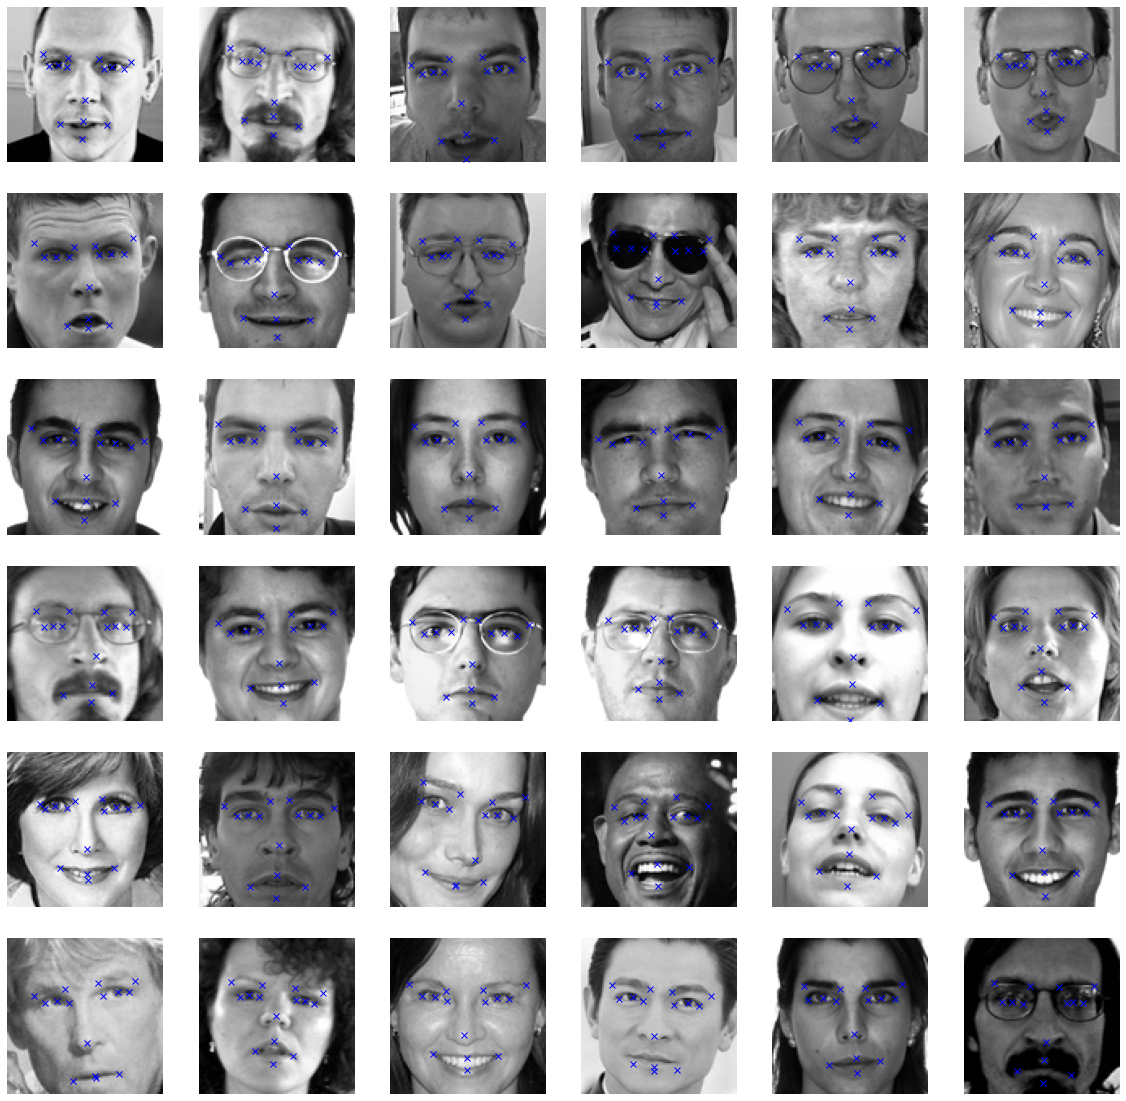

In [27]:
plot_datasets_using_images_and_keypoints(flipped_train_images, flipped_train_keypoints, 6,6)

In [28]:
X_new = np.concatenate((X, flipped_train_images))
labels_new = np.concatenate((labels, flipped_train_keypoints))

In [29]:
X_new.shape, labels_new.shape

((4280, 96, 96, 1), (4280, 30))

In [30]:
def augment_images_rotation(images, keypoints, rotation_angles_list):
  
  rotated_images = []
  rotated_keypoints = []
  
  for image_data, points in zip(images, keypoints):

    points = points - 48
    #print("Points after -48",points)
    rotation_angle = np.random.choice(rotation_angles_list)
    image_center = tuple(np.array(image_data.shape[1::-1]) / 2)
    images_rotate_matrix = cv2.getRotationMatrix2D(image_center, rotation_angle, 1.0) 
    result = cv2.warpAffine(image_data, images_rotate_matrix, image_data.shape[1::-1], flags=cv2.INTER_LINEAR)
  
    rotated_images.append(np.expand_dims(result,axis=2))

    rotation_angle = -rotation_angle*pi/180. 
    new_points = [points[idx]*cos(rotation_angle) - points[idx+1]*sin(rotation_angle) 
                  if idx%2 == 0 else points[idx]*cos(rotation_angle) + points[idx-1]*sin(rotation_angle) for idx, point in enumerate(points)]
    #print(new_points)
    #new_points = new_points+48
    rotated_keypoints.append(new_points)

  return np.array(rotated_images), np.array(rotated_keypoints)+48


In [31]:
if ROTATE_IMAGES:
  rotated_image, rotated_keypoints = augment_images_rotation(X_new,labels_new, [30, 45, 60, -30, -45, -60, 15, -15])
  X_new = np.concatenate((X_new, rotated_image))
  labels_new = np.concatenate((labels_new, rotated_keypoints))
else:
  rotated_image, rotated_keypoints = [], []

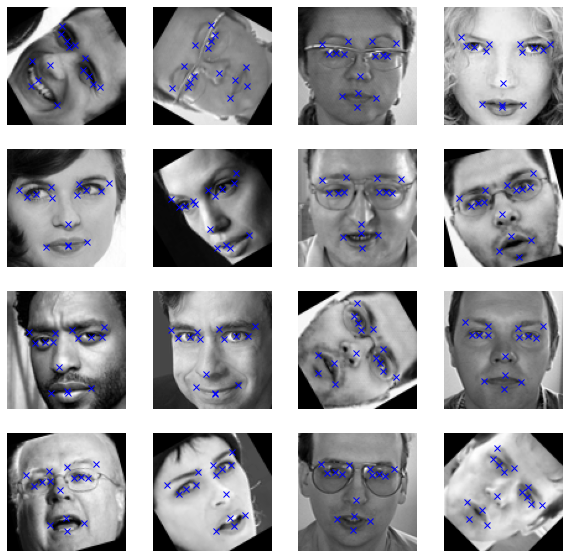

In [32]:
plot_datasets_using_images_and_keypoints(X_new, labels_new, 4, 4, (10,10))

In [33]:
def change_image_brightness(images, keypoints, n_augmented=100):
  resultant_image = []
  resultant_keypoints = []
  for i in range(n_augmented):
    index1 = np.random.randint(0,len(images))
    resultant_image.append(np.clip(images[index1]*1.3, 0, 1))
    resultant_keypoints.append(keypoints[index1])
    index2 = np.random.randint(0,len(images))
    resultant_image.append(np.clip(images[index2]*0.5, 0, 1))
    resultant_keypoints.append(keypoints[index2])

  return resultant_image, resultant_keypoints



In [34]:
image_bright, keypoint_bright = change_image_brightness(X_new, labels_new)

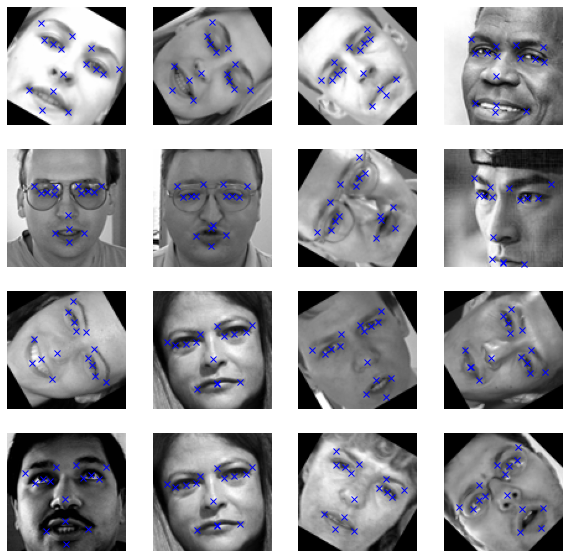

In [35]:
plot_datasets_using_images_and_keypoints(image_bright, keypoint_bright, 4,4, (10,10))

In [36]:
if MODIFY_IMAGE_INTENSITY:
  X_new = np.concatenate((X_new, image_bright))
  labels_new = np.concatenate((labels_new, keypoint_bright))
else:
  image_bright, keypoint_bright = [], []

In [64]:
def create_noisy_images(images, keypoints, noise_factor=0.9, n_augmented=100):
  noisy_images = []
  noisy_keypoints = []
  for i in range(0,n_augmented):
    index = np.random.randint(0,len(images))
    rows, cols = images[index].shape[0], images[index].shape[1]
    mean, var = 0, 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(rows,cols))
    gauss = gauss.reshape(rows,cols)
    noisy_image = images[index][:,:,0] + noise_factor*gauss
    noisy_images.append(np.expand_dims(noisy_image,axis=2))
    noisy_keypoints.append(keypoints[index])

  return np.array(noisy_images), np.array(noisy_keypoints)

In [69]:
if ADD_NOISE_To_IMAGES:
  noisy_img, noisy_keypoint = create_noisy_images(X_new, labels_new, 0.15, 800)
else:
  noisy_img, noisy_keypoint = [], []

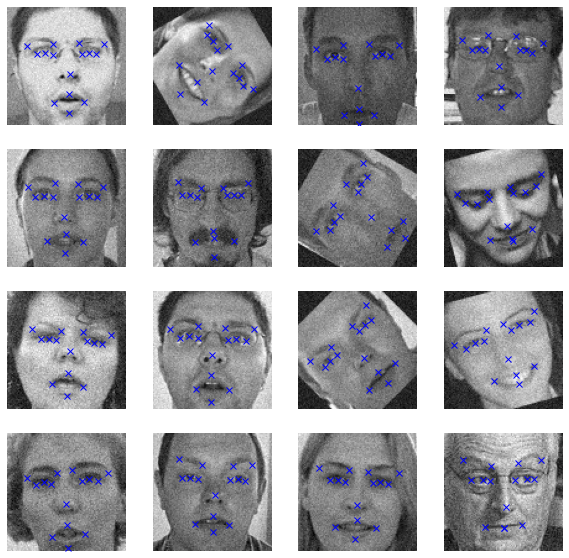

In [70]:
plot_datasets_using_images_and_keypoints(noisy_img, noisy_keypoint, 4,4, (10,10))

In [71]:
if ADD_NOISE_To_IMAGES:
  X_new = np.concatenate((X_new, noisy_img))
  labels_new = np.concatenate((labels_new, noisy_keypoint))



In [80]:
model = keras.models.Sequential()

# Input dimensions: (None, 96, 96, 1)
model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 96, 96, 32)
model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 48, 48, 32)
model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 48, 48, 64)
model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 24, 24, 64)
model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 24, 24, 96)
model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 12, 12, 96)
model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 12, 12, 128)
model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 6, 6, 128)
model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 6, 6, 256)
model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 3, 3, 256)
model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 3, 3, 512)
model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

# Input dimensions: (None, 3, 3, 512)
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)       

In [81]:
NUM_EPOCHS = 100
BATCH_SIZE = 128

In [86]:
# Load a pre-trained model (if present)
if os.path.exists('Facial_keypoint_detection_model.hdf5'):
    model = load_model('Facial_keypoint_detection_model.hdf5')

# Define necessary callbacks
checkpointer = ModelCheckpoint(filepath = 'Facial_keypoint_detection_model.hdf5', monitor='val_mae', verbose=1, save_best_only=True, mode='min')

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'acc'])

# Train the model
history = model.fit(X_new, labels_new, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_split=0.25, callbacks=[checkpointer])

Epoch 1/100
57/57 [==============================] - ETA: 0s - loss: 244.8448 - mae: 11.7001 - acc: 0.3552
Epoch 00001: val_mae improved from inf to 34.38956, saving model to Facial_keypoint_detection_model.hdf5
57/57 [==============================] - 10s 169ms/step - loss: 244.8448 - mae: 11.7001 - acc: 0.3552 - val_loss: 1426.9086 - val_mae: 34.3896 - val_acc: 0.2887
Epoch 2/100
56/57 [============================>.] - ETA: 0s - loss: 133.4769 - mae: 8.0395 - acc: 0.4467
Epoch 00002: val_mae improved from 34.38956 to 13.15851, saving model to Facial_keypoint_detection_model.hdf5
57/57 [==============================] - 9s 153ms/step - loss: 133.4896 - mae: 8.0401 - acc: 0.4466 - val_loss: 308.6198 - val_mae: 13.1585 - val_acc: 0.3000
Epoch 3/100
56/57 [============================>.] - ETA: 0s - loss: 105.3456 - mae: 6.9272 - acc: 0.4745
Epoch 00003: val_mae did not improve from 13.15851
57/57 [==============================] - 8s 146ms/step - loss: 105.3741 - mae: 6.9283 - acc: 0.4

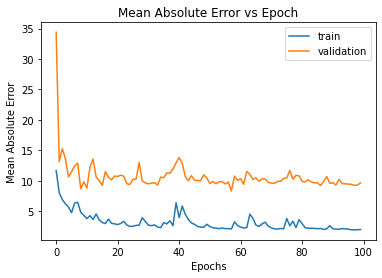

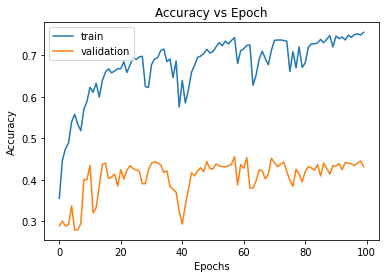

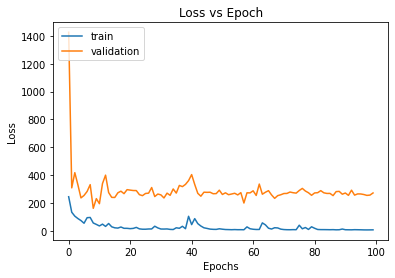

In [87]:
try:
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Mean Absolute Error vs Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Accuracy vs Epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss vs Epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
except:
    print("One of the metrics used for plotting graphs is missing! See 'model.compile()'s `metrics` argument.")

In [88]:
test_dataFrame = pd.read_csv('test.csv')

In [89]:
test_dataFrame['Image'] = test_dataFrame['Image'].apply(lambda x: np.fromstring(x, dtype=int, sep = ' '))
test_dataFrame['Image'] = test_dataFrame['Image'].apply(lambda x: x.reshape(96,96))

In [90]:
test_images = cleanedDataFrame['Image']
test_images = test_images/255.0
X_test = np.empty((len(test_images), 96, 96, 1))
for i in range(len(test_images)):
    X_test[i,:] = np.expand_dims(test_images[i], axis=2)

X_test = np.asarray(X_test).astype(np.float32)

print(X_test.shape)

(2140, 96, 96, 1)


In [91]:
predict_out = model.predict(X_test)

In [98]:
rotated_test, _ = augment_images_rotation(X_test, labels_new[0:len(X_test)], [45,15,25,-30,-45, -60])

In [99]:
rotated_test.shape

(2140, 96, 96, 1)

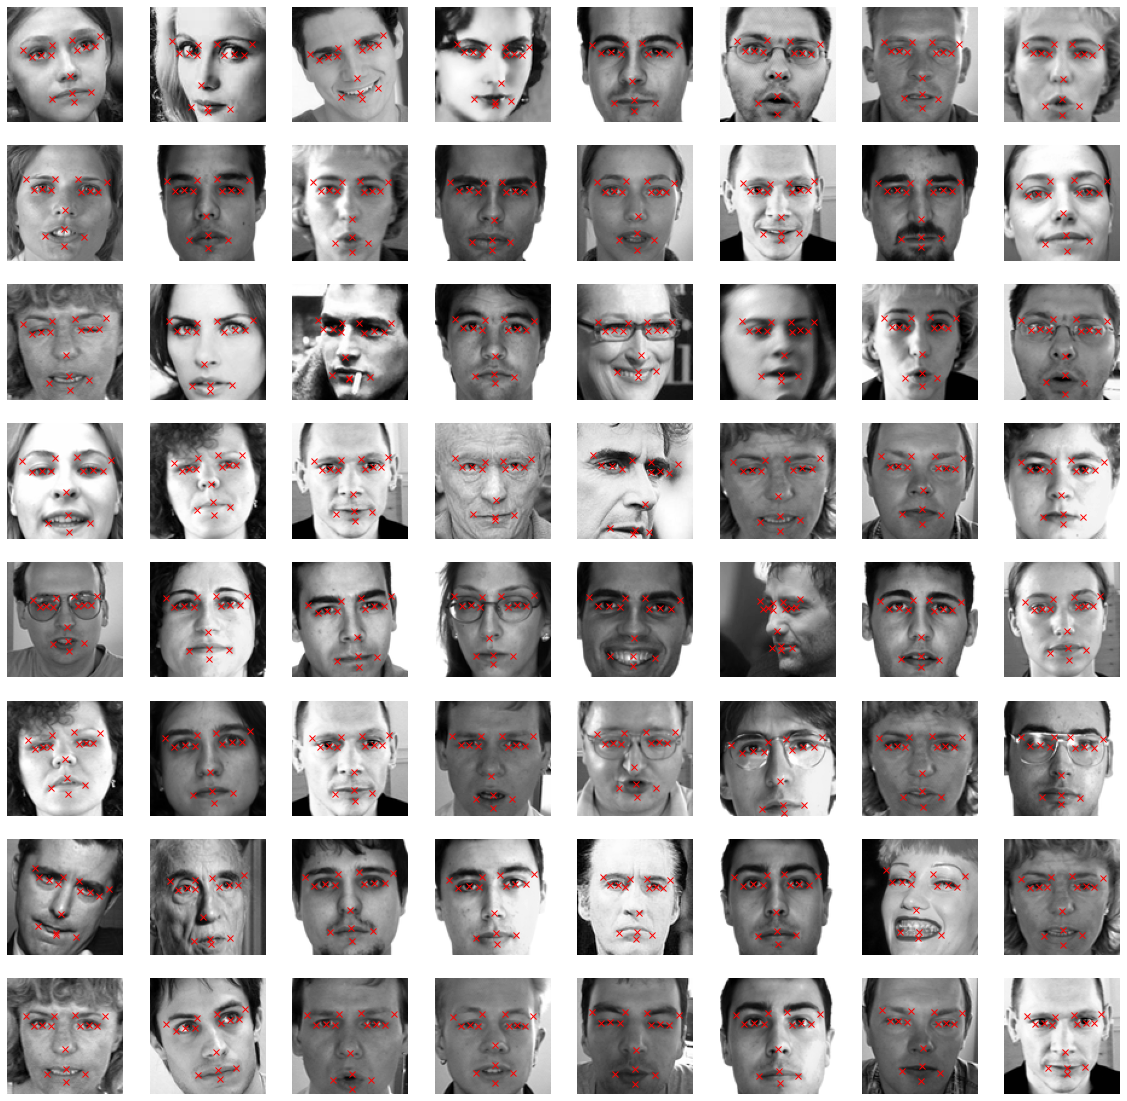

In [92]:
n_rows, n_cols = 8,8
fig, axes = plt.subplots(n_rows,n_cols,figsize = (20,20))
axes = axes.ravel()

for i in range(0,n_rows*n_cols):
  index = np.random.randint(0,len(X_test))
  axes[i].imshow(test_images[index], cmap='gray')
  for j in range(1,31,2):
    axes[i].plot(predict_out[index][j-1], predict_out[index][j], 'rx')
    #axes[i].set_title(y_train[i], fontsize = 8)
  axes[i].axis('off')

In [100]:
rotated_predict = model.predict(rotated_test)

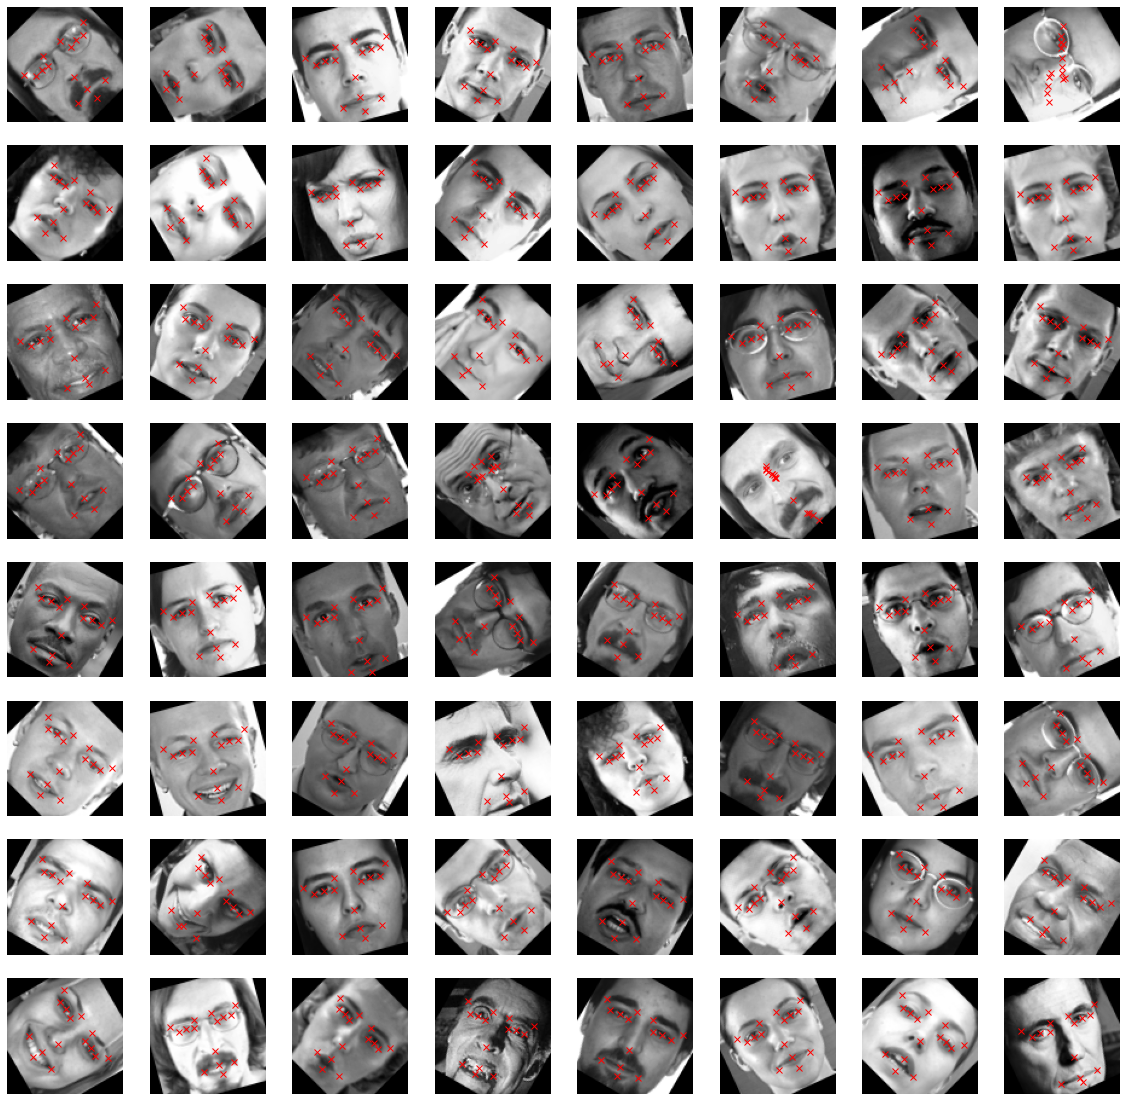

In [102]:
n_rows, n_cols = 8,8
fig, axes = plt.subplots(n_rows,n_cols,figsize = (20,20))
axes = axes.ravel()

for i in range(0,n_rows*n_cols):
  index = np.random.randint(0,len(X_test))
  axes[i].imshow(rotated_test[index][:,:,0], cmap='gray')
  for j in range(1,31,2):
    axes[i].plot(rotated_predict[index][j-1], rotated_predict[index][j], 'rx')
    #axes[i].set_title(y_train[i], fontsize = 8)
  axes[i].axis('off')